In [1]:
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.playback.video_playback import *

from typing import Iterable

def iter_files(directory: Path, suffix: str = None, keyword_match: str = None) -> Iterable[Path]:
    """Iterate files filtered by extension/suffix and optional filename keyword."""
    if not directory.exists():
        return []
    files = sorted(p for p in directory.iterdir() if p.is_file())
    if suffix:
        token = suffix.lower()
        if token.startswith("."):
            files = [f for f in files if f.suffix.lower() == token]
        else:
            files = [f for f in files if f.name.lower().endswith(token)]
    if keyword_match:
        key = keyword_match.lower()
        files = [f for f in files if key in f.name.lower()]
    return files

In [2]:
F, H, W = (200, 253, 760)

bw_file_root = Path(r"G:\MeOH_test\Mie\Processed_Results\Postprocessed_Data")

test_point_number = 1

match_str = f"T{test_point_number}_"

# All files that end with ...
boundary_files = iter_files(bw_file_root, suffix="boundary_points.csv", keyword_match=match_str)

ptr_lists = []

In [3]:
rep = len(boundary_files)

bw_videos = np.zeros((rep, F, H, W))

for r in range(rep):
    bw_vid, ptrs = load_boundary_file(boundary_files[r], return_BW_video=True, F=F, H=H, W=W)
    bw_videos[r] = bw_vid
    ptr_lists.append(ptrs)


In [4]:
probability_heatmap = np.sum(bw_videos, axis=0)  / float(rep) / 255.0

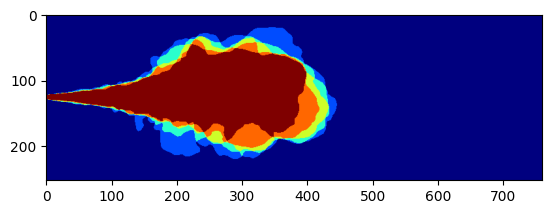

In [5]:
plt.imshow(probability_heatmap[50], cmap="jet")

In [6]:
play_video_cv2(probability_heatmap)

In [7]:
probability_heatmap_half = probability_heatmap > 0.5

In [8]:
probability_heatmap_half.shape

(200, 253, 760)

In [9]:
# --- Split: compute all boundary points (no x-band filter) ---
def _boundary_points_one_frame(bw, connectivity=2, x_scale=1.0):
    """
    Compute all boundary points of a single binary frame without x-band filtering.

    Returns: (coords_top_all, coords_bottom_all) as (N,2) int32 arrays (y, x).
    """
    H, W = bw.shape
    struct = generate_binary_structure(2, 2 if connectivity == 2 else 1)
    boundary = bw & ~binary_erosion(bw, structure=struct, border_value=0)
    if not boundary.any():
        return (np.empty((0, 2), dtype=np.int32), np.empty((0, 2), dtype=np.int32))

    ys, xs = np.nonzero(boundary)
    if ys.size == 0:
        return (np.empty((0, 2), dtype=np.int32), np.empty((0, 2), dtype=np.int32))

    mid = (H - 1) / 2.0
    top_mask = ys <= mid
    bot_mask = ~top_mask

    mid_val = np.asarray(mid, dtype=ys.dtype)

    ys -= mid_val   # Centering to 0
    xs = x_scale*xs.astype(np.float16)   # Correction by linear projection 
    
    coords_top = np.column_stack((ys[top_mask], xs[top_mask])) # .astype(np.int32)
    coords_bot = np.column_stack((ys[bot_mask], xs[bot_mask])) # .astype(np.int32)
    return coords_top, coords_bot

In [10]:
half_pts = bw_boundaries_single_plume(probability_heatmap_half)

NameError: name 'bw_boundaries_single_plume' is not defined

In [ ]:
len(half_pts)

200

In [ ]:
play_video_with_boundaries_cv2(probability_heatmap, half_pts)

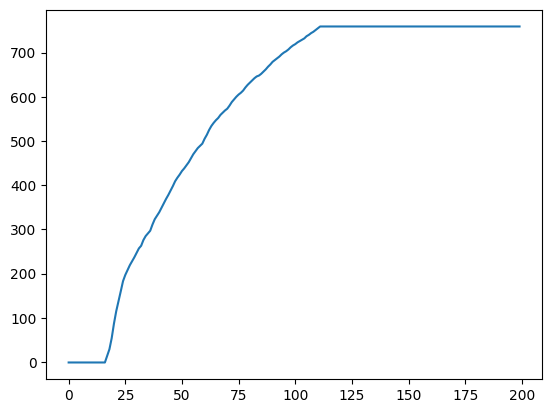

In [ ]:
penetration = penetration_bw_to_index(np.sum(probability_heatmap_half, axis=1) > 0) 
plt.plot(penetration)

In [ ]:
bw_boundaries_xband_filter__single_plume(half_pts, penetration)

NameError: name 'bw_boundaries_xband_filter__single_plume' is not defined